In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    plot_precision_recall_curve,
    f1_score,
    confusion_matrix,
    classification_report,
)
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateScheduler,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
tf.__version__

'2.1.0'

## Do some early processing of your metadata for easier model training:

In [37]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
98406,00026004_001.png,Mass,1,26004,63,F,PA,2330,2568,0.143,0.143,NaN,/data/images_011/images/00026004_001.png
55187,00013825_000.png,Atelectasis,0,13825,67,M,PA,2500,2048,0.168,0.168,NaN,/data/images_007/images/00013825_000.png
38921,00010179_001.png,Atelectasis,1,10179,62,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010179_001.png


In [38]:
diseases = []
for val in all_xray_df["Finding Labels"]:
    diseases.extend(val.split("|")) # We can do that because there is no NaNs.
                                    # Otherwise we should use try/except block with AttributeError
diseases = list(sorted(set(diseases)))
    
print(f"Num of diseases found: {len(diseases)}. \nDiseases: {diseases}")

def split_label(label, disease):
    return 1 if label.find(disease) > -1 else 0

for disease in diseases:
    all_xray_df[disease] = all_xray_df["Finding Labels"].apply(lambda x: split_label(x, disease))

Num of diseases found: 15. 
Diseases: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [39]:
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [40]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
def check_pneumonia(arg):
    return "pneumonia" if arg == 1 else "non pneumonia"

all_xray_df["pneumonia_class"] = all_xray_df["Pneumonia"].apply(check_pneumonia)
all_xray_df["pneumonia_class"].value_counts()

non pneumonia    110689
pneumonia          1431
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [41]:
def create_splits(df, label_col, test_size):
    """
    Splits the data from the provided df argument into the test and validation set.
    Split ratio is specified by test_size.
    """
    
    train_data, val_data = train_test_split(df, test_size=test_size, stratify=df[label_col], random_state=99)
    
    return train_data, val_data

In [42]:
train_data, val_data = create_splits(all_xray_df, "Pneumonia", 0.2)
test_data, val_data = create_splits(val_data, "Pneumonia", 0.5)

train_ratio = train_data["Pneumonia"].sum() / len(train_data["Pneumonia"])
valid_ratio = val_data["Pneumonia"].sum() / len(val_data["Pneumonia"])
test_ratio = test_data["Pneumonia"].sum() / len(test_data["Pneumonia"])

print(f"Train data shape: {train_data.shape}\tPneumonia ratio: {train_ratio:.4f}")
print(f"Valid data shape: {val_data.shape}\tPneumonia ratio: {valid_ratio:.4f}")
print(f"Test data shape: {test_data.shape}\tPneumonia ratio: {test_ratio:.4f}")

Train data shape: (89696, 29)	Pneumonia ratio: 0.0128
Valid data shape: (11212, 29)	Pneumonia ratio: 0.0128
Test data shape: (11212, 29)	Pneumonia ratio: 0.0128


<b>Pneumonia cases are only around 1.2% of all cases. That's extremely imbalanced dataset and model will really struggle with making decisions in this case. I've decided to reduce number of negative (healthy) examples to be closer to positive (pneumonia) cases.</b>

In [43]:
total_pneumonia_cases = all_xray_df["Pneumonia"].sum()
print(total_pneumonia_cases)

1431


In [44]:
non_pneumonia_ind = all_xray_df[all_xray_df["Pneumonia"] == 0].sample(total_pneumonia_cases).index
pneumonia_ind = all_xray_df[all_xray_df["Pneumonia"] == 1].index

In [45]:
pneumonia_df = all_xray_df.loc[non_pneumonia_ind.append(pneumonia_ind)].sample(frac=1)

Now we can create our split one more time with new dataframe

In [46]:
train_data, val_data = create_splits(pneumonia_df, "Pneumonia", 0.2)
test_data, val_data = create_splits(val_data, "Pneumonia", 0.5)

train_ratio = train_data["Pneumonia"].sum() / len(train_data["Pneumonia"])
valid_ratio = val_data["Pneumonia"].sum() / len(val_data["Pneumonia"])
test_ratio = test_data["Pneumonia"].sum() / len(test_data["Pneumonia"])

print(f"Train data shape: {train_data.shape}\tPneumonia ratio: {train_ratio:.4f}")
print(f"Valid data shape: {val_data.shape}\tPneumonia ratio: {valid_ratio:.4f}")
print(f"Test data shape: {test_data.shape}\tPneumonia ratio: {test_ratio:.4f}")

Train data shape: (2289, 29)	Pneumonia ratio: 0.4998
Valid data shape: (287, 29)	Pneumonia ratio: 0.5017
Test data shape: (286, 29)	Pneumonia ratio: 0.5000


# Now we can begin our model-building & training

We will erform some image augmentation on our data

In [47]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

def my_image_augmentation():
    data_gen = ImageDataGenerator(
        rescale = 1./255.,
        samplewise_center=True,
        samplewise_std_normalization=True,
        horizontal_flip = True, 
        rotation_range = 10, 
        brightness_range = (0.8, 1.2),
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range = (0.9, 1.1),
        preprocessing_function = preprocess_input,
    )
    
    return data_gen


def make_train_gen(data_gen, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = data_gen.flow_from_dataframe(
        dataframe = train_df, 
        directory = None,
        x_col = "path",
        y_col = "pneumonia_class",
        class_mode = "binary",
        target_size = IMG_SIZE, 
        batch_size = BATCH_SIZE,
    )

    return train_gen


def make_gen(data_gen, df):
    
    gen = data_gen.flow_from_dataframe(
        dataframe = df, 
        directory = None,
        x_col = "path",
        y_col = "pneumonia_class",
        class_mode = "binary",
        target_size = IMG_SIZE, 
        batch_size = BATCH_SIZE,
    )

    return gen

In [48]:
img_generator = ImageDataGenerator(
    rescale=1./255.,
    samplewise_center=True,
    samplewise_std_normalization=True,
    preprocessing_function=preprocess_input
)

train_gen = make_train_gen(my_image_augmentation(), train_data)
valid_gen = make_gen(img_generator, val_data)
test_gen = make_gen(img_generator, test_data)

Found 2289 validated image filenames belonging to 2 classes.
Found 287 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.


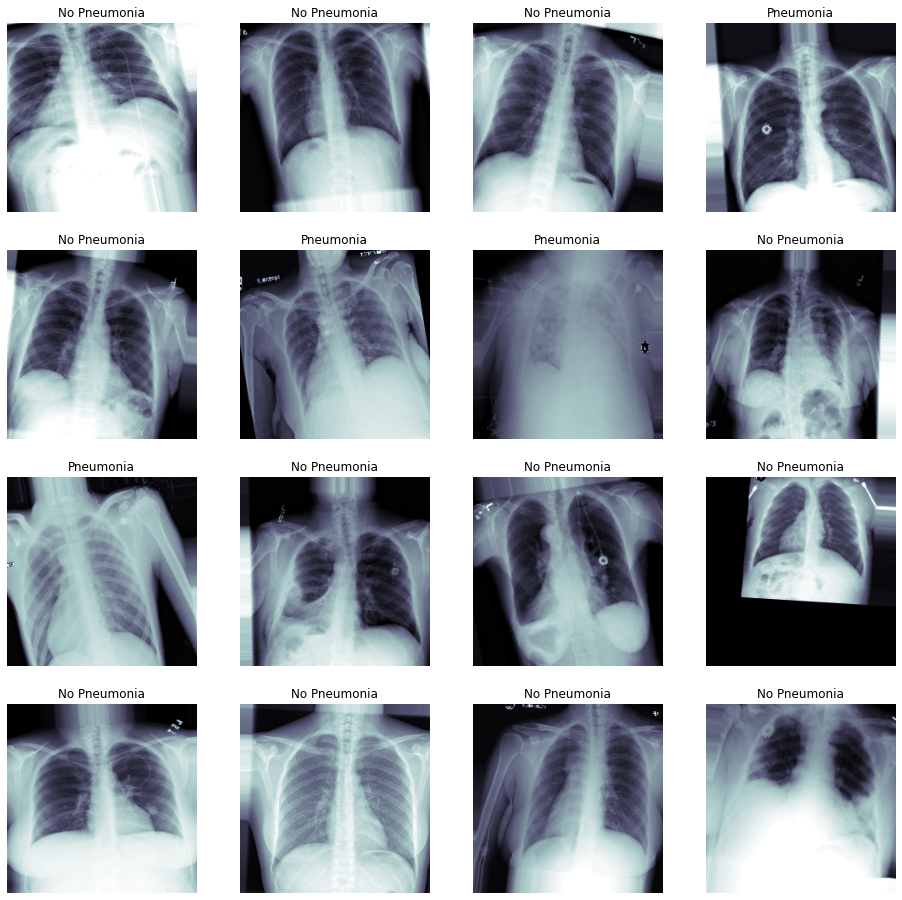

In [49]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build model: 

I will use model pre-trained on imagenet dataset to take advantage of network layers that are already specialized to recognize certain general shapes 

In [50]:
def load_pretrained_model():
    model = VGG19(include_top=False, weights="imagenet")
    model.trainable = True
    
    for layer in model.layers[:12]:
        layer.trainable = False
        
    return model

In [51]:
def build_my_model():
    
    my_model = tf.keras.Sequential([
        load_pretrained_model(),
        GlobalAveragePooling2D(),
        Dense(1024, activation="relu"),
        Dropout(0.4),
        BatchNormalization(),
        Dense(1024, activation="relu"),
        Dropout(0.4),
        BatchNormalization(),
        Dense(256, activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        Dense(64, activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
        
    ])
    
    return my_model

In [52]:
my_model = build_my_model()
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)             

In [53]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(
    monitor="val_loss",
    filepath=weight_path,
    save_best_only=True,
    verbose=1
)

early = EarlyStopping(
    monitor="val_loss", 
    mode="auto",
    patience=5,
    restore_best_weights=True,
)


callbacks_list = [
    checkpoint,
    early,
]

In [54]:
my_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "Precision",
        "Recall",
        "AUC"
    ],
)

### Start training! 

In [55]:
## train model
epochs = 15

history = my_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 36 steps, validate for 5 steps
Epoch 1/15
35/36 [============================>.] - ETA: 2s - loss: 0.8347 - Precision: 0.5234 - Recall: 0.5210 - AUC: 0.5281
Epoch 00001: val_loss improved from inf to 2178.85215, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 82s 2s/step - loss: 0.8362 - Precision: 0.5210 - Recall: 0.5210 - AUC: 0.5277 - val_loss: 2178.8521 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.5000
Epoch 2/15
35/36 [============================>.] - ETA: 1s - loss: 0.7755 - Precision: 0.5189 - Recall: 0.5212 - AUC: 0.5325
Epoch 00002: val_loss improved from 2178.85215 to 1.64150, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 75s 2s/step - loss: 0.7741 - Precision: 0.5206 - Recall: 0.5201 - AUC: 0.5343 - val_loss: 1.6415 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.5820
Epoch 3/15
35/36 [============

In [56]:
results = my_model.evaluate(test_gen)
results

  ...
    to  
  ['...']
5/5 [==============================] - 6s 1s/step - loss: 0.6471 - Precision: 0.6439 - Recall: 0.5944 - AUC: 0.6885


[0.6470705032348633, 0.6439394, 0.5944056, 0.6885422]

Well, those are not the best values... AUC metrics that say how the model is capable to distinguish two classes have value 0.69 on the test set. This is not surprising because we have only ~3000 images on a task which is really hard even for professional radiologists.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [57]:
testX, testY = next(test_gen)
predictions = my_model.predict(testX, verbose=True)

64/64 [==============================] - 1s 14ms/sample


In [58]:
predictions = predictions.reshape(-1)

In [59]:
t1 = (predictions > 0.60).astype("int32")
t2 = (predictions > 0.51).astype("int32")

compare_t1 = (t1 == testY)
compare_t2 = (t2 == testY)

In [60]:
compare_t1.astype("int32");
compare_t2.astype("int32");

In [61]:
print('Accuracy at threshold 1: ', sum(compare_t1) / len(predictions))
print('Accuracy at threshold 2: ', sum(compare_t2) / len(predictions))

Accuracy at threshold 1:  0.53125
Accuracy at threshold 2:  0.71875


In [62]:
THRESHOLD = 0.51
predY = (predictions > THRESHOLD).astype("int32")

In [63]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


def plot_precision_recall(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


def plot_history(history):
    acc = history.history['AUC']
    val_acc = history.history['val_loss']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training AUC')
    plt.plot(val_acc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.5])
    plt.title('Training and Validation AUC')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.5])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(0.5))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Correctly predicted as healthy (True Negatives): ', cm[0][0])
    print('Incorrectly detected as sick (False Positives): ', cm[0][1])
    print('Incorrectly detected as healthy (False Negatives): ', cm[1][0])
    print('Correctly detected as sick (True Positives): ', cm[1][1])
    print('Total number of sick patients: ', np.sum(cm[1]))

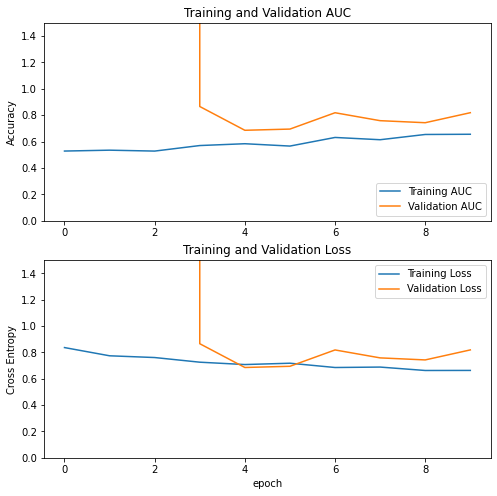

In [64]:
## plot figures
plot_history(history)

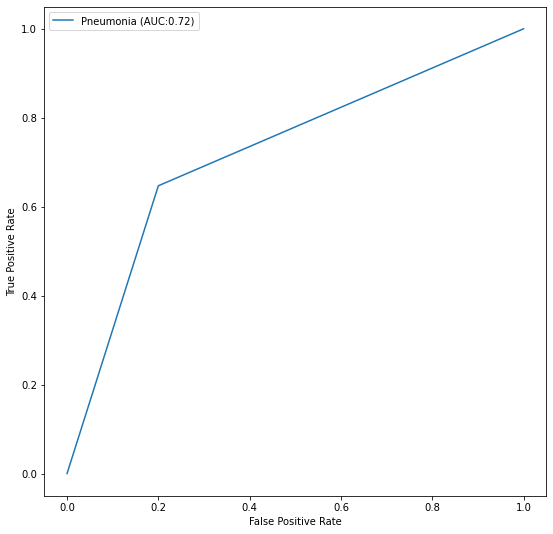

In [65]:
plot_auc(testY, predY)

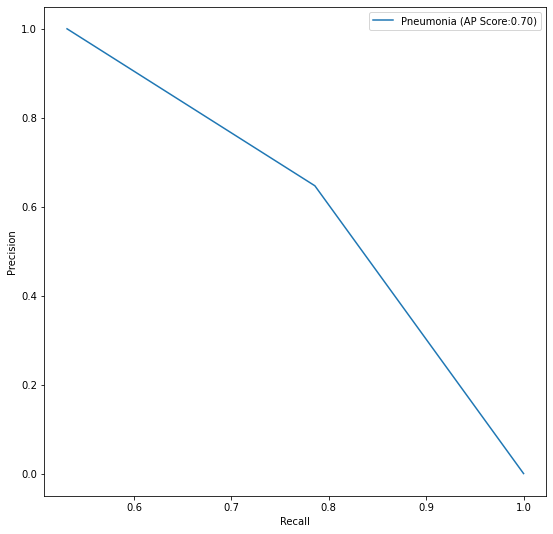

In [66]:
plot_precision_recall(testY, predY)

Correctly predicted as healthy (True Negatives):  24
Incorrectly detected as sick (False Positives):  6
Incorrectly detected as healthy (False Negatives):  12
Correctly detected as sick (True Positives):  22
Total number of sick patients:  34


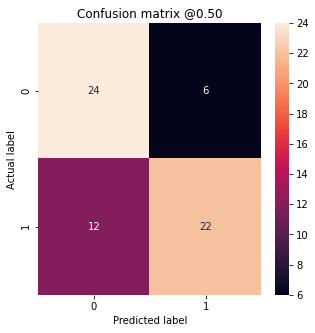

In [67]:
plot_cm(testY, predY)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

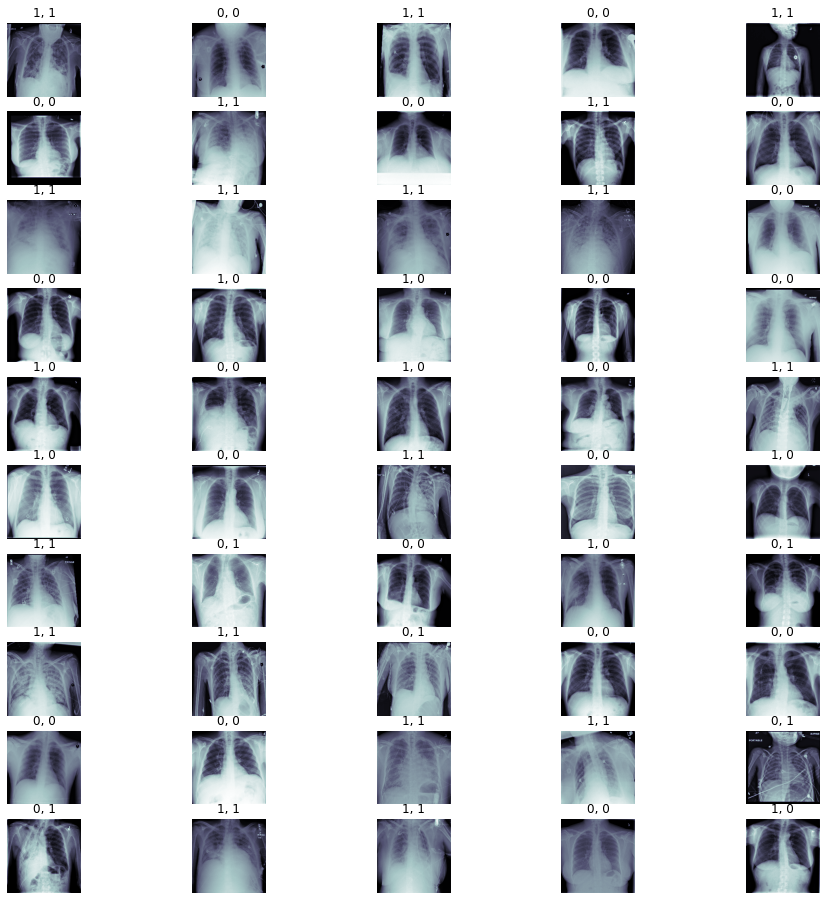

In [68]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:50], testY[0:50], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if predY[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
# save model

model_json = my_model.to_json();

with open('my_model.json', 'w') as json_file:
    json.dump(model_json, json_file)